<font size = 6>Automatically Exercised Parisian Options’ Pricing and Hedging Strategies - Auto-Exercised Parisian Option Hedging Strategies</font>
<font size = 4><div style="text-align: right"> Contributor: Haochen Jiang</div></font>
<font size = 4><div style="text-align: right"> May 8, 2021</div></font>

In [4]:
import psutil as ps
import time

print("PC Physical CPU Number : {}.".format(ps.cpu_count()))
print("PC Logical CPU Number : {}.".format(ps.cpu_count(logical=False)))
print("PC Total Memory : {} bytes.".format(ps.virtual_memory().total))
print("PC Used Memory : {} bytes.".format(ps.virtual_memory().used))
print("PC Used Memory Accounts for : {}%.".format(ps.virtual_memory().percent))

PC Physical CPU Number : 32.
PC Logical CPU Number : 8.
PC Total Memory : 269763182592 bytes.
PC Used Memory : 18869809152 bytes.
PC Used Memory Accounts for : 7.7%.


In [5]:
! pip install sobol_seq
! pip install ghalton

You should consider upgrading via the '/opt/conda/bin/python -m pip install --upgrade pip' command.
You should consider upgrading via the '/opt/conda/bin/python -m pip install --upgrade pip' command.


In [3]:
from scipy.stats import norm
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sobol_seq
import pandas as pd
from decimal import Decimal
import ghalton

## Normal Distribution Sequence Generating Fuctions

In [4]:
def Box_Muller(x):
    if x.ndim == 1:
        y = np.random.rand(x.shape[0])
    elif x.ndim == 2:
        y = np.random.rand(x.shape[0], x.shape[1])
    else:
        raise ValueError("Input Error: ndim is out of range!")
    return (-2 * np.log(x)) ** 0.5 * np.cos(2 * np.pi * y)


def quasi_seq_uniform_to_randomized_std_normal(x):
    if x.ndim == 1:
        y = np.random.rand(x.shape[0])
    elif x.ndim == 2:
        y = np.random.rand(x.shape[0], x.shape[1])
    else:
        raise ValueError("Input Error: ndim is out of range!")
    return Box_Muller(np.mod(x + y, 1))

## Brownian Motion Paths Iteration Fuctions

In [5]:
def S_iteration(epsilon_matrix, M, N, dt, mu, sigma, S0):
    if type(epsilon_matrix) != np.ndarray:
        raise ValueError("Input Error: type of epsilon_matrix must be numpy.ndarray!")
    if epsilon_matrix.shape != (N, M):
        raise ValueError("Input Error: epsilon_matrix does NOT match M and N!")
    coefficient_matrix_tmp = np.insert(
        epsilon_matrix * sigma * np.sqrt(dt) + 1 + mu * dt, 0, values=1, axis=0
    )
    coefficient_matrix = coefficient_matrix_tmp.cumprod(axis=0)
    stock_price_paths_S = S0 * coefficient_matrix
    mean_S = stock_price_paths_S.mean(axis=1)
    final_S = stock_price_paths_S[-1, :]
    return (stock_price_paths_S, mean_S, final_S)

In [6]:
def lnS_iteration(epsilon_matrix, M, N, dt, mu, sigma, S0):
    if type(epsilon_matrix) != np.ndarray:
        raise ValueError("Input Error: type of epsilon_matrix must be numpy.ndarray!")
    if epsilon_matrix.shape != (N, M):
        raise ValueError("Input Error: epsilon_matrix does NOT match M and N!")
    epsilon_coefficient = epsilon_matrix.cumsum(axis=0) * sigma * np.sqrt(dt)
    constant_matrix = np.ones((N, M)).cumsum(axis=0)
    constant_coefficient = constant_matrix * dt * (mu - 0.5 * sigma ** 2)
    coefficient_matrix = np.insert(
        np.exp(epsilon_coefficient + constant_coefficient), 0, values=1, axis=0
    )
    stock_price_paths_lnS = S0 * coefficient_matrix
    mean_lnS = stock_price_paths_lnS.mean(axis=1)
    final_lnS = stock_price_paths_lnS[-1, :]
    return (stock_price_paths_lnS, mean_lnS, final_lnS)

## Vanilla Option Related Fucitons

In [7]:
def analytic_vanilla(cp_flag, S0_vec, K, T, r, sigma, q=0.0):
    N = norm.cdf
    n = norm.pdf
    d1 = (np.log(S0_vec / K) + (r - q + sigma ** 2 / 2.0) * T) / (sigma * np.sqrt(T))
    d2 = d1 - sigma * np.sqrt(T)
    if cp_flag == "call":
        V = S0_vec * np.exp(-q * T) * N(d1) - K * np.exp(-r * T) * N(d2)
    else:
        V = K * np.exp(-r * T) * N(-d2) - S0_vec * np.exp(-q * T) * N(-d1)
    return V


def analytic_vanilla_delta(cp_flag, S0_vec, K, T, r, sigma, q=0.0):
    N = norm.cdf
    n = norm.pdf
    d1 = (np.log(S0_vec / K) + (r - q + sigma ** 2 / 2.0) * T) / (sigma * np.sqrt(T))
    d2 = d1 - sigma * np.sqrt(T)
    if cp_flag == "call":
        delta = np.exp(-q * T) * N(d1)
    else:
        delta = np.exp(-q * T) * (N(d1) - 1)
    return delta


def analytic_vanilla_gamma(cp_flag, S0_vec, K, T, r, sigma, q=0.0):
    N = norm.cdf
    n = norm.pdf
    d1 = (np.log(S0_vec / K) + (r - q + sigma ** 2 / 2.0) * T) / (sigma * np.sqrt(T))
    d2 = d1 - sigma * np.sqrt(T)
    if cp_flag == "call":
        gamma = (
            np.exp(-(d1 ** 2) / 2)
            / np.sqrt(2 * np.pi)
            * np.exp(-q * T)
            / (S0_vec * sigma * np.sqrt(T))
        )
    else:
        gamma = (
            np.exp(-(d1 ** 2) / 2)
            / np.sqrt(2 * np.pi)
            * np.exp(-q * T)
            / (S0_vec * sigma * np.sqrt(T))
        )
    return gamma

In [8]:
def mc_vanilla(
    cp_flag,
    M,
    T,
    K,
    mu,
    sigma,
    S0_vec,
    art="n",
    quasi="n",
    skip=0,
    randomize="n",
    sampling_method="direct",
):

    if sampling_method == "direct":
        pass
    else:
        raise ValueError(
            "Input Error: Incorrect passed parameter sampling_method! "
            + "Sampling_method of fuction mc_vanilla can only be direct"
        )

    if quasi == "y":
        quasi_epsilon_vec = sobol_seq.i4_sobol_generate(1, M, skip)
    elif quasi == "n":
        pass
    else:
        raise ValueError("Input Error: Incorrect passed parameter quasi!")

    if art == "y":
        stock_price_paths_vec_art = {}
    elif art == "n":
        pass
    else:
        raise ValueError("Input Error: Incorrect passed parameter art!")

    result_vec = []
    stock_price_paths_vec = {}
    if art == "y":
        stock_price_paths_vec_art = {}

    for S0 in S0_vec:
        if quasi == "y":
            if randomize == "y":
                epsilon_vec = quasi_seq_uniform_to_randomized_std_normal(
                    quasi_epsilon_vec
                )
            elif randomize == "n":
                epsilon_vec = Box_Muller(quasi_epsilon_vec)
            else:
                raise ValueError("Input Error: Incorrect passed parameter randomize!")
        else:
            epsilon_vec = np.random.normal(0, 1, (M, 1))
        if art == "y":
            stock_price_paths_vec_art[S0] = S0 * np.exp(
                (mu - 0.5 * sigma ** 2) * T + sigma * np.sqrt(T) * (-epsilon_vec)
            )
        stock_price_paths_vec[S0] = S0 * np.exp(
            (mu - 0.5 * sigma ** 2) * T + sigma * np.sqrt(T) * epsilon_vec
        )

    stock_price_paths_vec = [stock_price_paths_vec]
    if art == "y":
        stock_price_paths_vec.append(stock_price_paths_vec_art)

    for i in range(len(stock_price_paths_vec)):
        end_price = pd.DataFrame(np.zeros((M, S0_vec.shape[0])), columns=S0_vec)
        for j in range(S0_vec.shape[0]):
            end_price.iloc[:, j] = stock_price_paths_vec[i][S0_vec[j]]

        discount = np.exp(
            -mu * pd.DataFrame(np.ones((M, S0_vec.shape[0])), columns=S0_vec) * T
        )
        if cp_flag == "call":
            end_value = (
                pd.DataFrame(np.where(end_price > K, end_price - K, 0), columns=S0_vec)
                * discount
            )
        elif cp_flag == "put":
            end_value = (
                pd.DataFrame(np.where(K > end_price, K - end_price, 0), columns=S0_vec)
                * discount
            )
        result_vec.append(end_value.mean(axis=0))

    return (result_vec[0] + result_vec[1]) / 2 if art == "y" else result_vec[0]

## Fitting Fuctions

In [9]:
def polyfit(fitting_y, deg, fitting_x=None):
    if fitting_x == None:
        fitting_x = list(fitting_y.index)
    fitting_coefficient = np.polyfit(list(fitting_y.index), fitting_y, deg)
    fitting_result = np.polyval(fitting_coefficient, fitting_x)
    return pd.DataFrame(fitting_result, index=fitting_x)

In [10]:
def expfit(fitting_y, deg, fitting_x=None):
    if fitting_x == None:
        fitting_x = list(fitting_y.index)
    fitting_coefficient = np.polyfit(list(fitting_y.index), np.log(fitting_y), deg)
    fitting_result = np.polyval(fitting_coefficient, fitting_x)
    return pd.DataFrame(np.exp(fitting_result), index=fitting_x)

## Greeks Difference Fucitons

In [11]:
def delta(pricing_vec):
    delta_vec = (pricing_vec.shift(-1) - pricing_vec.shift(1)).dropna() / (
        pricing_vec.index[2] - pricing_vec.index[0]
    )
    return delta_vec


def gamma(pricing_vec):
    gamma_vec = (
        (pricing_vec.shift(-1) + pricing_vec.shift(1) - 2 * pricing_vec).dropna()
        / (pricing_vec.index[1] - pricing_vec.index[0]) ** 2
        / 2
    )
    return gamma_vec

## ART Analysis Fuctions

In [12]:
def art_effeciency_analysis(F1, F2, S0_vec):
    corr_vec = {}
    estimate1_vec = {}
    estimate2_vec = {}
    estimate_vec = {}
    for i in S0_vec:
        tmp1 = F1.iloc[:, (i - S0_vec[0])]
        tmp2 = F2.iloc[:, (i - S0_vec[0])]
        tmp = pd.DataFrame([tmp1, tmp2]).T
        corr_vec[i] = tmp.corr().iloc[0, 1]
        estimate1_vec[i] = tmp.mean().iloc[0]
        estimate2_vec[i] = tmp.mean().iloc[1]
        estimate_vec[i] = tmp.mean().mean()
    corr_vec = pd.DataFrame(corr_vec, index=[0]).T
    estimate1_vec = pd.DataFrame(estimate1_vec, index=[0]).T
    estimate2_vec = pd.DataFrame(estimate2_vec, index=[0]).T
    estimate_vec = pd.DataFrame(estimate_vec, index=[0]).T
    return (corr_vec, estimate1_vec, estimate2_vec, estimate_vec)

In [13]:
def art_effeciency_analysis_show(X, analytic_vec, S0_vec):
    fig = plt.figure(figsize=(20, 12))
    ax1 = fig.add_subplot(1, 1, 1)
    ax1.plot(S0_vec, np.zeros(S0_vec.shape), color="k")
    ax1.plot(S0_vec, X[1] - analytic_vec, marker="o", label="Standard Estimation1")
    ax1.plot(S0_vec, X[2] - analytic_vec, marker="^", label="Standard Estimation2")
    ax1.plot(
        S0_vec, X[3] - analytic_vec, marker="s", color="r", label="ART Estimation",
    )
    plt.xlim(S0_vec[0], S0_vec[-1])
    plt.xlabel("Monte Carlo Simulation - S0", fontsize=22)
    plt.ylabel("Estimation Deviation", fontsize=22)
    plt.legend(fontsize=22, loc="upper left")
    plt.xticks(fontsize=18)
    plt.yticks(fontsize=18)

    ax2 = ax1.twinx()
    ax2.plot(
        S0_vec, X[0], color="g", label="Standard Estimation Correlation Coefficient"
    )
    plt.legend(fontsize=22, loc="upper right")
    plt.yticks(fontsize=18)
    plt.ylabel("Correlation Coefficient", fontsize=22)

# Hedging Strategies

In [26]:
greeks_address = "F:/Data/Greeks Data"
mc_address = "F:/Data/Monte Carlo Data"

In [27]:
# Import Data
gamma_data = pd.read_csv(greeks_address + "/gamma_tau=5.csv")
delta_data = pd.read_csv(greeks_address + "/delta_tau=5.csv")

In [28]:
gamma_data.index = gamma_data.iloc[:, 0]
gamma_data.drop(columns=["Unnamed: 0"], inplace=True)
gamma = gamma_data.iloc[25:]
gamma_front = pd.DataFrame(
    np.zeros(np.arange(0.1, 68.6, 0.1).shape), index=np.arange(0.1, 68.6, 0.1)
)
gamma_rear = pd.DataFrame(
    np.zeros(np.arange(113.9, 200.1, 0.1).shape), index=np.arange(113.9, 200.1, 0.1)
)
gamma_vec = [gamma_front, gamma, gamma_rear]
gamma_vec = pd.concat(gamma_vec)
gamma_vec.iloc[685:1138, 0] = gamma_vec.iloc[685:1138, 1]
gamma_vec = gamma_vec.iloc[:, 0]

In [29]:
delta_data.index = delta_data.iloc[:, 0]
delta_data.drop(columns=["Unnamed: 0"], inplace=True)
delta = delta_data
delta_front = pd.DataFrame(
    np.zeros(np.arange(0.1, 73, 0.1).shape), index=np.arange(0.1, 73, 0.1)
)
delta_rear = pd.DataFrame(
    np.zeros(np.arange(115.1, 200.1, 0.1).shape), index=np.arange(115.1, 200.1, 0.1)
)
delta_vec = [delta_front, delta, delta_rear]
delta_vec = pd.concat(delta_vec)
delta_vec.iloc[729:1150, 0] = delta_vec.iloc[729:1150, 1]
delta_vec = delta_vec.iloc[:, 0]

In [37]:
%%time
TN_vec = [
    (Decimal("126"), Decimal("0.5"), 6),
    (Decimal("105"), Decimal("0.41666667"), 5),
    (Decimal("84"), Decimal("0.33333333"), 4),
    (Decimal("63"), Decimal("0.25"), 3),
    (Decimal("42"), Decimal("0.16666667"), 2),
    (Decimal("21"), Decimal("0.08333333"), 1),
]
PADOC_price_vec = np.zeros(6)

for N, T, i in TN_vec:
    PADOC_price_vec[i - 1] = mc_standard_auto_parisian_DOC(
        100000, N, T, 90, 80, 0.05, 0.35, np.array([88]), 5
    )

PADOC_price = pd.DataFrame(PADOC_price_vec)
PADOC_price_T = PADOC_price.iloc[-1]
risk_free_PADOC_price_T = np.exp(0.5 * 0.05) * PADOC_price_T
expect_income = float(risk_free_PADOC_price_T - PADOC_price_T)

Wall time: 25min 40s


In [30]:
def mc_standard_auto_parisian_DOC_analyze(M):
    N = Decimal("126")
    T = Decimal("0.5")
    H = 90
    K = 80
    mu = 0.05
    sigma = 0.35
    tau = 5
    S0_vec = np.array([88])
    window = window_generate((Decimal("0"), T), T, T / N)
    T = float(T)
    N = int(N)
    dt = T / N
    end_time_vec = []
    end_price_vec = []
    end_payoff_vec = []
    quasi_epsilon_matrix = sobol_seq.i4_sobol_generate(1, N * M, 2000).reshape(N, M)

    stock_price_paths_vec = stock_price_paths_iteration(
        M, N, dt, mu, sigma, S0_vec, "y", "y", "lnS", quasi_epsilon_matrix
    )

    for i in range(len(stock_price_paths_vec)):
        tmp = auto_parisian_rule(
            stock_price_paths_vec[i], M, N, H, S0_vec, window, "y", tau
        )
        end_time = tmp[0]
        end_price = tmp[1]
        end_payoff = pd.DataFrame(
            np.where(end_price > K, end_price - K, 0), columns=S0_vec
        )
        end_time_vec.append(end_time)
        end_price_vec.append(end_price)
        end_payoff_vec.append(end_payoff)

    stock_price_paths_vec = [
        pd.DataFrame(stock_price_paths_vec[0][88]),
        pd.DataFrame(stock_price_paths_vec[1][88]),
    ]

    return (
        pd.concat(stock_price_paths_vec, axis=1, ignore_index=True).T,
        pd.concat(end_time_vec, ignore_index=True),
        pd.concat(end_price_vec, ignore_index=True),
        pd.concat(end_payoff_vec, ignore_index=True),
    )

In [161]:
%%time

# Calculate Data
all_results = mc_standard_auto_parisian_DOC_analyze(10000)
stock_price_paths = all_results[0]
end_time = all_results[1]
end_price = all_results[2]
end_payoff = all_results[3]

Wall time: 36.4 s


In [163]:
# Export Data
stock_price_paths.to_hdf(mc_address + "/stock_price_paths.h5", "stock_price_paths")
end_time.to_hdf(mc_address + "/end_time.h5", "end_time")
end_price.to_hdf(mc_address + "/end_price.h5", "end_price")
end_payoff.to_hdf(mc_address + "/end_payoff.h5", "end_payoff")

In [32]:
# Import Data
stock_price_paths = pd.read_hdf(mc_address + "/stock_price_paths.h5")
end_time = pd.read_hdf(mc_address + "/end_time.h5")
end_price = pd.read_hdf(mc_address + "/end_price.h5")
end_payoff = pd.read_hdf(mc_address + "/end_payoff.h5")

## Dynamic Hedging Strategy

In [38]:
def dynamic_hedging_simulation(
    stock_price_paths, end_time, end_payoff, gamma_vec, delta_vec
):
    observation_time = np.arange(4, 105, 5)
    hedging_income_vec = []
    PADOC_payoff_vec = []

    for i in range(stock_price_paths.shape[0]):
        stock_price_path = stock_price_paths.iloc[i]
        exercise_time = int(end_time.iloc[i])
        adjust_time = observation_time[observation_time < exercise_time]
        adjust_price = stock_price_paths.iloc[i, adjust_time]

        adjust_loc = pd.DataFrame(np.zeros(adjust_price.shape))
        adjust_gamma = pd.DataFrame(np.zeros(adjust_price.shape))
        adjust_delta = pd.DataFrame(np.zeros(adjust_price.shape))
        for j in range(len(adjust_price)):
            adjust_loc.iloc[j] = abs(
                np.array(gamma_vec.index) - adjust_price.iloc[j]
            ).argmin()
            adjust_gamma.iloc[j] = gamma_vec.iloc[int(adjust_loc.iloc[j])]
            adjust_delta.iloc[j] = delta_vec.iloc[int(adjust_loc.iloc[j])]

        adjust_option_maturity = 0.5 - adjust_time / 252
        adjust_option_price = pd.DataFrame(np.zeros(adjust_price.shape))
        adjust_option_delta = pd.DataFrame(np.zeros(adjust_price.shape))
        adjust_option_gamma = pd.DataFrame(np.zeros(adjust_price.shape))
        for j in range(len(adjust_price)):
            adjust_option_price.iloc[j] = analytic_vanilla(
                "call", adjust_price.iloc[j], 80, adjust_option_maturity[j], 0.05, 0.35
            )
            adjust_option_delta.iloc[j] = analytic_vanilla_delta(
                "call", adjust_price.iloc[j], 80, adjust_option_maturity[j], 0.05, 0.35
            )
            adjust_option_gamma.iloc[j] = analytic_vanilla_gamma(
                "call", adjust_price.iloc[j], 80, adjust_option_maturity[j], 0.05, 0.35
            )

        adjust_gamma_cal = adjust_gamma.copy()
        adjust_gamma_cal.iloc[1:] = adjust_gamma - adjust_gamma.shift(1)
        adjust_option_gamma_cal = adjust_option_gamma.copy()
        adjust_option_gamma_cal.iloc[
            1:
        ] = adjust_option_gamma - adjust_option_gamma.shift(1)
        option_operation = pd.DataFrame(np.zeros(adjust_price.shape))
        for x in range(len(adjust_price)):
            option_operation.iloc[x] = (
                -(
                    adjust_gamma_cal.iloc[x]
                    + option_operation.sum() * adjust_option_gamma_cal.iloc[x]
                )
                / adjust_option_gamma.iloc[x]
            )
        cum_option_operation = option_operation.cumsum()

        option_cum_delta = cum_option_operation * adjust_option_delta
        option_diff_delta = option_cum_delta.copy()
        option_diff_delta.iloc[1:] = option_cum_delta - option_cum_delta.shift(1)
        adjust_delta_cal = adjust_delta.copy()
        adjust_delta_cal.iloc[1:] = adjust_delta - adjust_delta.shift(1)
        underlying_operation = pd.DataFrame(np.zeros(adjust_price.shape))
        for x in range(len(adjust_price)):
            underlying_operation.iloc[x] = -(
                option_diff_delta.iloc[x] + adjust_delta_cal.iloc[x]
            )
        cum_underlying_operation = underlying_operation.cumsum()

        # Verifying Code - The following two must near 0
        # cum_underlying_operation + cum_option_operation * adjust_option_delta + adjust_delta
        # cum_option_operation * adjust_option_gamma + adjust_gamma

        option_operation_flow = -option_operation * adjust_option_price
        underlying_operation_flow = -underlying_operation * pd.DataFrame(
            np.array(adjust_price)
        )

        all_option_operation_flow = option_operation_flow.sum()
        all_underlying_operation_flow = underlying_operation_flow.sum()

        option_flow = max(stock_price_path.iloc[-1] - 80, 0) * option_operation.sum()
        underlying_flow = stock_price_path.iloc[-1] * underlying_operation.sum()

        hedging_income = (
            all_option_operation_flow
            + all_underlying_operation_flow
            + option_flow
            + underlying_flow
        )
        PADOC_payoff = float(end_payoff.iloc[i])
        hedging_income_vec.append(hedging_income)
        PADOC_payoff_vec.append(PADOC_payoff)

    return (hedging_income_vec, PADOC_payoff_vec)

In [165]:
%%time
# Calculate Data
dynamic_hedging_results = dynamic_hedging_simulation(
    stock_price_paths, end_time, end_payoff, gamma_vec, delta_vec
)
hedging_income = pd.DataFrame(dynamic_hedging_results[0])
PADOC_payoff = pd.DataFrame(dynamic_hedging_results[1])

Wall time: 10min 11s


In [166]:
# Export Data
hedging_income.to_hdf(mc_address + "/hedging_income.h5", "hedging_income")
PADOC_payoff.to_hdf(mc_address + "/PADOC_payoff.h5", "PADOC_payoff")

In [39]:
# Import Data
hedging_income = pd.read_hdf(mc_address + "/hedging_income.h5")
PADOC_payoff = pd.read_hdf(mc_address + "/PADOC_payoff.h5")

In [40]:
PADOC_income = PADOC_payoff - float(PADOC_price_T)
total_income_dynamic = PADOC_income + hedging_income

Wall time: 91.9 ms


Text(0, 0.5, 'Revenue')

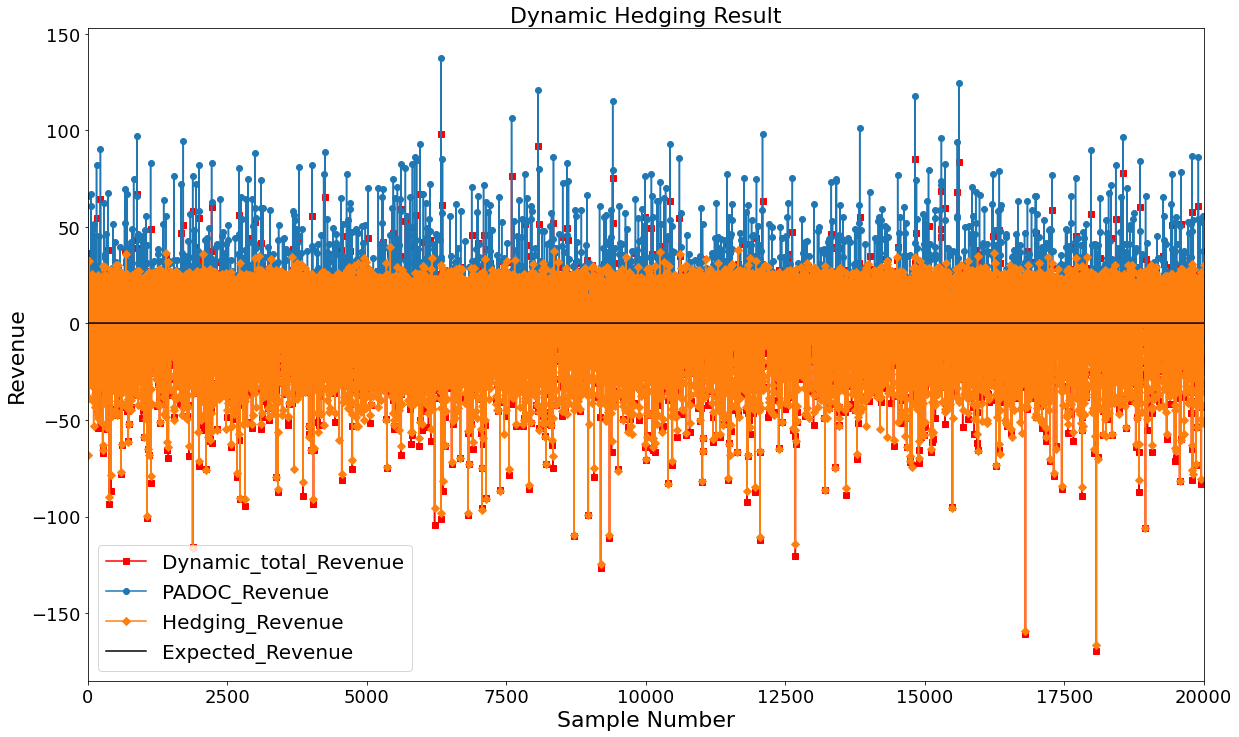

In [83]:
%%time
fig = plt.figure(figsize=(20, 12))
ax = fig.add_subplot(1, 1, 1)

plt.plot(total_income_dynamic, label="Dynamic_total_Revenue", marker="s", color="r")
plt.plot(PADOC_income, label="PADOC_Revenue", marker="o")
plt.plot(hedging_income, label="Hedging_Revenue", marker="D")
plt.plot(
    np.ones(PADOC_income.shape) * expect_income, label="Expected_Revenue", color="k"
)

plt.legend(fontsize=20)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.xlim(0, PADOC_income.shape[0])
plt.title("Dynamic Hedging Result", fontsize=22)
plt.xlabel("Sample Number", fontsize=22)
plt.ylabel("Revenue", fontsize=22)

Wall time: 58 ms


Text(0, 0.5, 'Revenue')

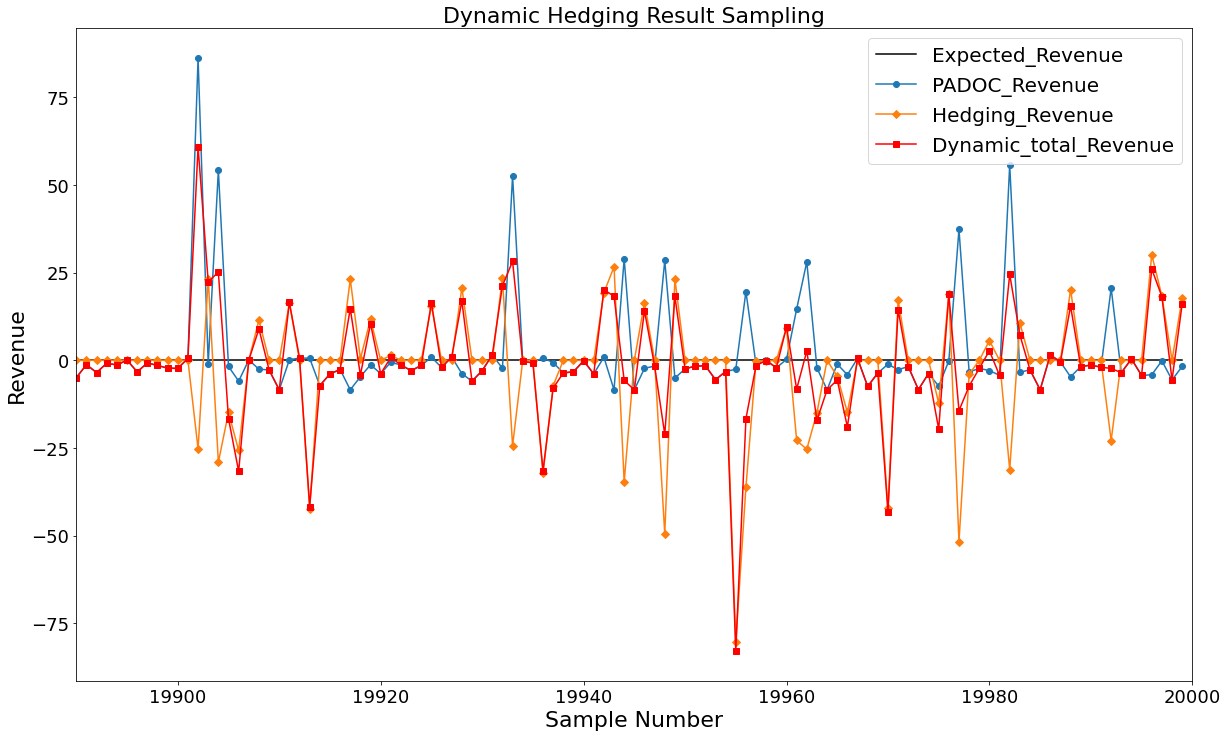

In [46]:
%%time
fig = plt.figure(figsize=(20, 12))
ax = fig.add_subplot(1, 1, 1)

sample = 110
plt.plot(
    np.ones(PADOC_income.shape) * expect_income, label="Expected_Revenue", color="k"
)
plt.plot(PADOC_income.iloc[-sample:], label="PADOC_Revenue", marker="o")
plt.plot(hedging_income.iloc[-sample:], label="Hedging_Revenue", marker="D")
plt.plot(
    total_income_dynamic.iloc[-sample:],
    label="Dynamic_total_Revenue",
    marker="s",
    color="r",
)

plt.xlim(PADOC_income.shape[0] - sample, PADOC_income.shape[0])
plt.legend(fontsize=20)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.title("Dynamic Hedging Result Sampling", fontsize=22)
plt.xlabel("Sample Number", fontsize=22)
plt.ylabel("Revenue", fontsize=22)

In [94]:
dynamic_hedging_measure = hedging_income.std() / float(PADOC_price_T)
print(dynamic_hedging_measure)

0    1.87423
dtype: float64


In [99]:
print((total_income_dynamic - expect_income).mean())

0   -0.766733
dtype: float64


In [116]:
neg_dynamic = np.array(total_income_dynamic.T - expect_income)
print(neg_dynamic[neg_dynamic < 0].std() / float(PADOC_price_T))

1.326127600711103


## Static Hedging Strategy

In [48]:
T_vec = np.arange(1, 7) / 12
analytic_vanilla_vec = np.zeros(6)
for j in range(T_vec.shape[0]):
    analytic_vanilla_vec[j] = analytic_vanilla("call", 88, 90, T_vec[j], 0.05, 0.35)

In [49]:
analytic_vanilla_vec = pd.DataFrame(analytic_vanilla_vec)
vanilla_position = pd.DataFrame(np.zeros(6))

In [50]:
PADOC_price_cal = PADOC_price.copy()
PADOC_price_cal.iloc[1:] = PADOC_price - PADOC_price.shift(1)

In [51]:
analytic_vanilla_cal = analytic_vanilla_vec.copy()
analytic_vanilla_cal = analytic_vanilla_vec - analytic_vanilla_vec.shift(1)
analytic_vanilla_cal = pd.DataFrame(np.array(analytic_vanilla_cal[::-1]))

In [52]:
for j in range(len(vanilla_position)):
    vanilla_position.iloc[j] = (
        PADOC_price_cal.iloc[j]
        - (analytic_vanilla_cal.shift(j - 5) * vanilla_position).sum()
    ) / analytic_vanilla_vec.iloc[0]

In [53]:
vanilla_position = pd.DataFrame(np.array(vanilla_position[::-1]))

# It can be used to verify results
vanilla_portfolio_value = pd.DataFrame(
    [
        (vanilla_position.shift(-5) * analytic_vanilla_vec).sum(),
        (vanilla_position.shift(-4) * analytic_vanilla_vec).sum(),
        (vanilla_position.shift(-3) * analytic_vanilla_vec).sum(),
        (vanilla_position.shift(-2) * analytic_vanilla_vec).sum(),
        (vanilla_position.shift(-1) * analytic_vanilla_vec).sum(),
        (vanilla_position * analytic_vanilla_vec).sum(),
    ]
)

In [54]:
analytic_vanilla_vec

,0
0,2.823949
1,4.445834
2,5.735614
3,6.849421
4,7.849164
5,8.766963


In [55]:
vanilla_position

,0
0,-0.056090
1,-0.102148
2,-0.165343
3,-0.362099
4,-1.642369
5,2.891102


In [56]:
PADOC_price

,0
0,8.164325
1,8.215396
2,8.257995
3,8.305628
4,8.343045
5,8.413914


In [57]:
stock_price_paths_cal = stock_price_paths.iloc[:, [21, 42, 63, 84, 105, 126]]
portfoilo_payoff_cal = pd.DataFrame(
    np.where(stock_price_paths_cal > 90, stock_price_paths_cal - 90, 0)
)

In [68]:
portfoilo_cost = float(PADOC_price_T)
portfolio_income = pd.DataFrame(
    pd.DataFrame(np.array(portfoilo_payoff_cal) * np.array(vanilla_position.T)).sum(
        axis=1
    )
)
portfolio_income -= portfoilo_cost
total_income_static = PADOC_income + portfolio_income

Wall time: 50 ms


Text(0, 0.5, 'Revenue')

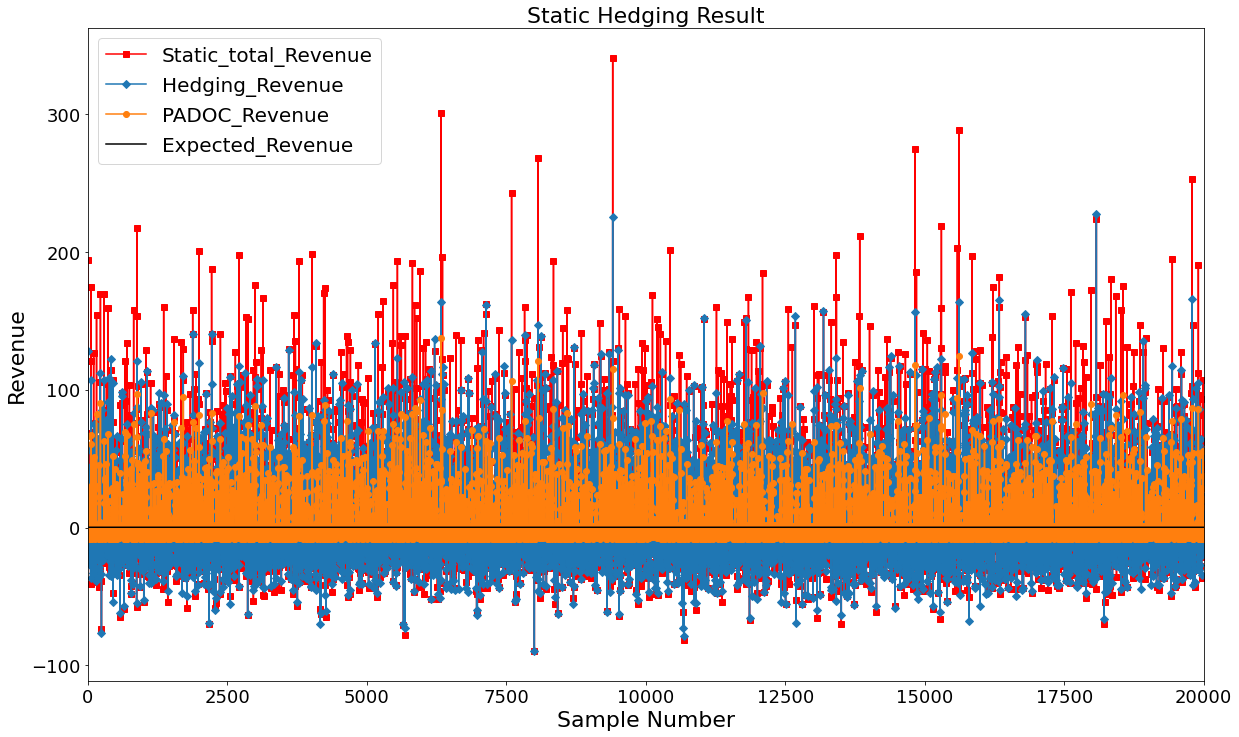

In [90]:
%%time
fig = plt.figure(figsize=(20, 12))
ax = fig.add_subplot(1, 1, 1)

plt.plot(total_income_static, label="Static_total_Revenue", marker="s", color="r")
plt.plot(portfolio_income, label="Hedging_Revenue", marker="D")
plt.plot(PADOC_income, label="PADOC_Revenue", marker="o")
plt.plot(
    np.ones(PADOC_income.shape) * expect_income, label="Expected_Revenue", color="k"
)

plt.xlim(0, PADOC_income.shape[0])
plt.legend(fontsize=20)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.title("Static Hedging Result", fontsize=22)
plt.xlabel("Sample Number", fontsize=22)
plt.ylabel("Revenue", fontsize=22)

Wall time: 43 ms


Text(0, 0.5, 'Revenue')

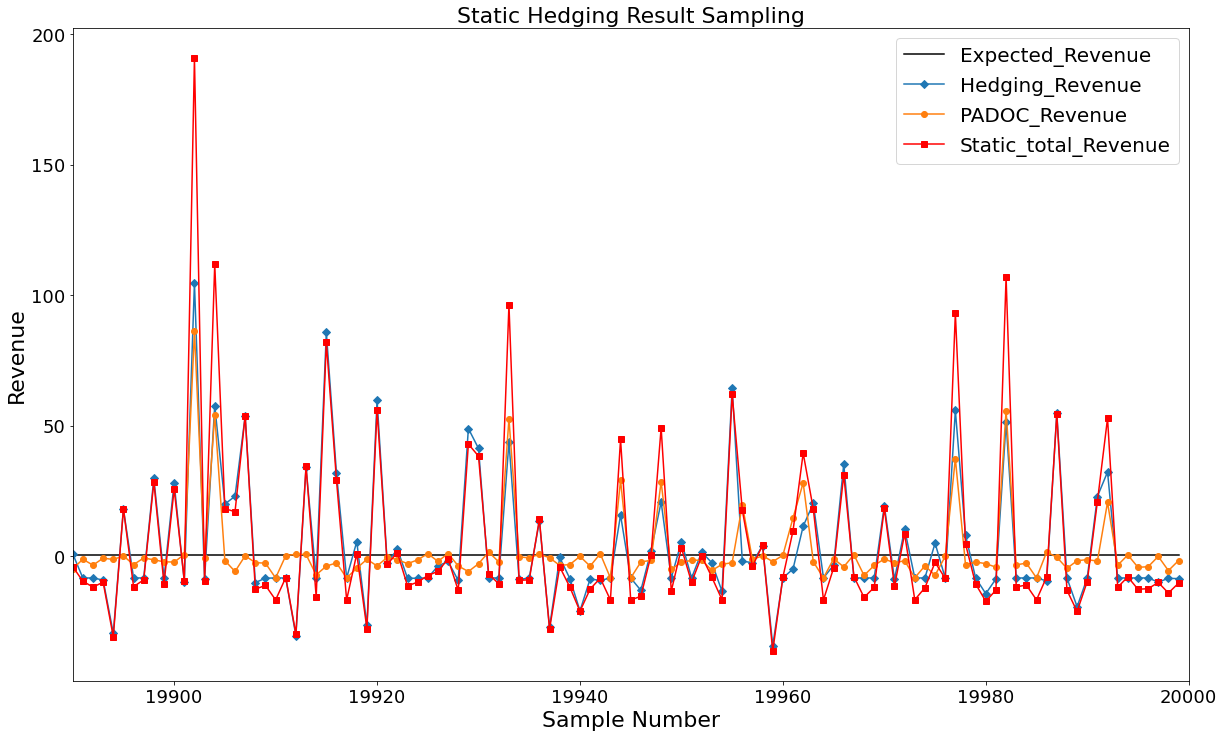

In [89]:
%%time
fig = plt.figure(figsize=(20, 12))
ax = fig.add_subplot(1, 1, 1)
sample = 110

plt.plot(
    np.ones(PADOC_income.shape) * expect_income, label="Expected_Revenue", color="k"
)
plt.plot(portfolio_income.iloc[-sample:], label="Hedging_Revenue", marker="D")
plt.plot(PADOC_income.iloc[-sample:], label="PADOC_Revenue", marker="o")
plt.plot(
    total_income_static.iloc[-sample:],
    label="Static_total_Revenue",
    marker="s",
    color="r",
)

plt.xlim(PADOC_income.shape[0] - sample, PADOC_income.shape[0])
plt.legend(fontsize=20)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.title("Static Hedging Result Sampling", fontsize=22)
plt.xlabel("Sample Number", fontsize=22)
plt.ylabel("Revenue", fontsize=22)

In [92]:
static_hedging_measure = portfolio_income.std() / float(PADOC_price_T)
print(static_hedging_measure)

0    2.852879
dtype: float64


In [100]:
print((total_income_static - expect_income).mean())

0    0.592708
dtype: float64


In [115]:
neg_static = np.array(total_income_static.T - expect_income)
print(neg_static[neg_static < 0].std() / float(PADOC_price_T))

0.8949596257597295
